In [ ]:
# default_exp analysis

# Analysis

> This contains fastai Learner extensions useful to perform prediction analysis.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import random_shuffle
from tsai.data.core import *
from tsai.inference import get_X_preds
from fastai.learner import * 

In [ ]:
#export
@patch
@delegates(subplots)
def show_probas(self:Learner, figsize=(6,6), ds_idx=1, dl=None, one_batch=False, max_n=None, **kwargs):
    recorder = copy(self.recorder) # This is to avoid loss of recorded values while generating preds
    if one_batch: dl = self.dls.one_batch()
    probas, targets = self.get_preds(ds_idx=ds_idx, dl=[dl] if dl is not None else None)
    if probas.ndim == 2 and probas.min() < 0 or probas.max() > 1: probas = nn.Softmax(-1)(probas)
    if not isinstance(targets[0].item(), Integral): return
    targets = targets.flatten()
    if max_n is not None:
        idxs = np.random.choice(len(probas), max_n, False)
        probas, targets = probas[idxs], targets[idxs]
    if isinstance(probas, torch.Tensor): probas = probas.detach().cpu().numpy()
    if isinstance(targets, torch.Tensor): targets = targets.detach().cpu().numpy()
    fig = plt.figure(figsize=figsize, **kwargs)
    classes = np.unique(targets)
    nclasses = len(classes)
    vals = np.linspace(.5, .5 + nclasses - 1, nclasses)[::-1]
    plt.vlines(.5, min(vals) - 1, max(vals), color='black', linewidth=.5)
    cm = plt.get_cmap('gist_rainbow')
    color = [cm(1.* c/nclasses) for c in range(1, nclasses + 1)][::-1]
    # class_probas = np.array([probas[i,t] for i,t in enumerate(targets)])
    class_probas = np.array([probas[i][t] for i,t in enumerate(targets)])
    for i, c in enumerate(classes):
        plt.scatter(class_probas[targets == c] if nclasses > 2 or i > 0 else 1 - class_probas[targets == c],
                    targets[targets == c] + .5 * (np.random.rand((targets == c).sum()) - .5), color=color[i], edgecolor='black', alpha=.2, s=100)
        if nclasses > 2: plt.vlines((targets == c).mean(), i - .5, i + .5, color='r', linewidth=.5)
    plt.hlines(vals, 0, 1)
    plt.ylim(min(vals) - 1, max(vals))
    plt.xlim(0,1)
    plt.xticks(np.linspace(0,1,11), fontsize=12)
    plt.yticks(classes, [self.dls.vocab[x] for x in classes], fontsize=12)
    plt.title('Predicted proba per true class' if nclasses > 2 else 'Predicted class 1 proba per true class', fontsize=14)
    plt.xlabel('Probability', fontsize=12)
    plt.ylabel('True class', fontsize=12)
    plt.grid(axis='x', color='gainsboro', linewidth=.2)
    plt.show()
    self.recorder = recorder

In [ ]:
#export
@patch
def plot_confusion_matrix(self:Learner, ds_idx=1, dl=None, thr=.5, normalize=False, title='Confusion matrix', cmap="Blues", norm_dec=2, figsize=(6,6),
                          title_fontsize=16, fontsize=12, plot_txt=True, **kwargs):
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        assert self.dls.cat
        if self.dls.c == 2: # binary classification
            probas, preds = self.get_preds(ds_idx=ds_idx, dl=dl)
            y_pred = (probas[:, 1] > thr).numpy().astype(int)
            y_test = preds.numpy()
            if normalize: skm_normalize = 'true'
            else: skm_normalize = None
            cm = skm.confusion_matrix(y_test, y_pred, normalize=skm_normalize)
        else: 
            cm = ClassificationInterpretation.from_learner(self).confusion_matrix()

        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(figsize=figsize, **kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        if self.dls.c == 2:
            plt.title(f"{title} (threshold: {thr})", fontsize=title_fontsize)
        else: 
            plt.title(title, fontsize=title_fontsize)
        tick_marks = np.arange(len(self.dls.vocab))
        plt.xticks(tick_marks, self.dls.vocab, rotation=90, fontsize=fontsize)
        plt.yticks(tick_marks, self.dls.vocab, rotation=0, fontsize=fontsize)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=fontsize)

        ax = fig.gca()
        ax.set_ylim(len(self.dls.vocab)-.5,-.5)

        plt.tight_layout()
        plt.ylabel('Actual', fontsize=fontsize)
        plt.xlabel('Predicted', fontsize=fontsize)
        plt.grid(False)

In [ ]:
#export
@patch
def feature_importance(self:Learner, X=None, y=None, partial_n=None, feature_names=None, key_metric_idx=0, show_chart=True, save_df_path=False,
                       random_state=23):
    r"""Calculates feature importance defined to be the change in a model validation loss or metric when a single feature value is randomly shuffled

    Adapted from https://www.kaggle.com/cdeotte/lstm-feature-importance by Chris Deotte (Kaggle GrandMaster)

    This procedure breaks the relationship between the feature and the target, thus the change in the model validation loss or metric is indicative of
    how much the model depends on the feature.

    Args:
        X: array-like object  containing the time series data for which importance will be measured. If None, all data in the validation set will be used.
        y: array-like object containing the targets. If None, all targets in the validation set will be used.
        partial_n: number of samples (if int) or percent of the validation set (if float) that will be used to measure feature importance. If None,
                   all data will be used.
        feature_names (Optional[list(str)]): list of feature names that will be displayed if available. Otherwise they will be var_0, var_1, etc.
        key_metric_idx (Optional[int]): integer to select the metric used in the calculation. If None or no metric is available,
                                        the change is calculated using the validation loss.
        show_chart (bool): flag to indicate if a chart showing permutation feature importance will be plotted.
        save_df_path (str): path to saved dataframe containing the permutation feature importance results.
        random_state (int): controls the shuffling applied to the data. Pass an int for reproducible output across multiple function calls.
    """

    if X is None:
        X = self.dls.valid.dataset.tls[0].items
    if y is None:
        y = self.dls.valid.dataset.tls[1].items
    if partial_n is not None:
        if isinstance(partial_n, float):
            partial_n = int(round(partial_n * len(X)))
        rand_idxs = random_shuffle(np.arange(len(X)), random_state=random_state)[:partial_n]
        X = X.oindex[rand_idxs] if hasattr(X, 'oindex') else X[rand_idxs]
        y = y.oindex[rand_idxs] if hasattr(y, 'oindex') else y[rand_idxs]

    metrics = [mn for mn in self.recorder.metric_names if mn not in ['epoch', 'train_loss', 'valid_loss', 'time']]
    if len(metrics) == 0 or key_metric_idx is None:
        metric_name = self.loss_func.__class__.__name__
        key_metric_idx = None
    else:
        metric_name = metrics[key_metric_idx]
        metric = self.recorder.metrics[key_metric_idx].func
    metric_name = metric_name.replace("train_", "").replace("valid_", "")
    print(f'Selected metric: {metric_name}')
    
    sel_vars = not(isinstance(self.dls.sel_vars, slice) and self.dls.sel_vars == slice(None, None, None))
    if feature_names is None:
        feature_names = L([f"var_{i}" for i in range(X.shape[1])])
        if sel_vars:
            feature_names = feature_names[self.dls.sel_vars]
    else:
        feature_names = listify(feature_names)
    
    if sel_vars:
        assert len(feature_names) == len(self.dls.sel_vars)
    else: 
        assert len(feature_names) == X.shape[1]
    
    sel_var_idxs = L(np.arange(1, X.shape[1] + 1).tolist())
    if sel_vars:
        sel_var_idxs = sel_var_idxs[self.dls.sel_vars]
    assert len(feature_names) == len(sel_var_idxs)

    g = list(zip(np.arange(len(sel_var_idxs)+2), [0] + sel_var_idxs))

    COLS = ['BASELINE'] + list(feature_names)
    results = []
    print('Computing feature importance...')
    try:
        for i,k in progress_bar(g):
            if k not in [0] + sel_var_idxs: continue
            if k>0:
                save_feat = X[:, k-1].copy()
                X[:, k-1] = random_shuffle(X[:, k-1].flatten(), random_state=random_state).reshape(X[:, k-1].shape)
            if key_metric_idx is None:
                value = self.get_X_preds(X, y, with_loss=True)[-1].mean().item()
            else:
                output = self.get_X_preds(X, y)
                value = metric(output[0], output[1]).item()
            print(f"{k:3} feature: {COLS[i]:20} {metric_name}: {value:8.6f}")
            results.append([COLS[i], value])
            del output, value;gc.collect()
            if k>0:
                X[:, k-1] = save_feat
                del save_feat; gc.collect()

    except KeyboardInterrupt:
        if k>0:
            X[:, k-1] = save_feat
            del save_feat; gc.collect()

    # Display feature importance
    if show_chart:
        print()
        df = pd.DataFrame(results, columns=["Feature", metric_name])
#         df = df.sort_values(metric_name, ascending=key_metric_idx is None)
        plt.figure(figsize=(10, .5*len(results)))
        plt.barh(np.arange(len(results)), df[metric_name], color="darkblue")
        plt.yticks(np.arange(len(results)), df["Feature"].values)
        plt.title('Permutation Feature Importance', size=16)
        plt.xlabel(f"{metric_name}")
        plt.ylim((-1,len(results)))
        plt.show()

    # Save feature importance
    if save_df_path:
        df = df.sort_values(metric_name,ascending=False)
        df.to_csv(f'{save_df_path}.csv', index=False)

In [ ]:
#export
@patch
def step_importance(self:Learner, X=None, y=None, partial_n=None, key_metric_idx=0, show_chart=True, save_df_path=False, random_state=23):
    r"""Calculates step importance defined to be the change in a model validation loss or metric when a single step value is randomly shuffled


    This procedure breaks the relationship between the step and the target, thus the change in the model validation loss or metric is indicative of
    how much the model depends on the step.

    Args:
        X: array-like object  containing the time series data for which importance will be measured. If None, all data in the validation set will be used.
        y: array-like object containing the targets. If None, all targets in the validation set will be used.
        partial_n: number of samples (if int) or percent of the validation set (if float) that will be used to measure feature importance. If None,
                   all data will be used.
        key_metric_idx (Optional[int]): integer to select the metric used in the calculation. If None or no metric is available,
                                        the change is calculated using the validation loss.
        show_chart (bool): flag to indicate if a chart showing permutation feature importance will be plotted.
        save_df_path (str): path to saved dataframe containing the permutation feature importance results.
        random_state (int): controls the shuffling applied to the data. Pass an int for reproducible output across multiple function calls.
    """

    if X is None:
        X = self.dls.valid.dataset.tls[0].items
    if y is None:
        y = self.dls.valid.dataset.tls[1].items
    if partial_n is not None:
        if isinstance(partial_n, float):
            partial_n = int(round(partial_n * len(X)))
        rand_idxs = random_shuffle(np.arange(len(X)), random_state=random_state)[:partial_n]
        X = X.oindex[rand_idxs] if hasattr(X, 'oindex') else X[rand_idxs]
        y = y.oindex[rand_idxs] if hasattr(y, 'oindex') else y[rand_idxs]

    metrics = [mn for mn in self.recorder.metric_names if mn not in ['epoch', 'train_loss', 'valid_loss', 'time']]
    if len(metrics) == 0 or key_metric_idx is None:
        metric_name = self.loss_func.__class__.__name__
        key_metric_idx = None
    else:
        metric_name = metrics[key_metric_idx]
        metric = self.recorder.metrics[key_metric_idx].func
    metric_name = metric_name.replace("train_", "").replace("valid_", "")
    print(f'Selected metric: {metric_name}')
    
    sel_steps = not(isinstance(self.dls.sel_steps, slice) and self.dls.sel_steps == slice(None, None, None))
    step_names = L([f"step_{i}" for i in range(X.shape[-1])])
    if sel_steps:
        step_names = step_names[self.dls.sel_steps]
        assert len(step_names) == len(np.arange(X.shape[-1])[self.dls.sel_steps])
    else: 
        assert len(step_names) == X.shape[-1]
    
    sel_step_idxs = L(np.arange(1, X.shape[-1] + 1).tolist())
    if sel_steps:
        sel_step_idxs = sel_step_idxs[self.dls.sel_steps]
    assert len(step_names) == len(sel_step_idxs)

    g = list(zip(np.arange(len(sel_step_idxs)+2), [0] + sel_step_idxs))

    COLS = ['BASELINE'] + list(step_names)
    results = []
    print('Computing feature importance...')
    try:
        for i,k in progress_bar(g):
            if k not in [0] + sel_step_idxs: continue
            if k>0:
                save_feat = X[..., k-1].copy()
                X[..., k-1] = random_shuffle(X[..., k-1].flatten(), random_state=random_state).reshape(X[..., k-1].shape)
            if key_metric_idx is None:
                value = self.get_X_preds(X, y, with_loss=True)[-1].mean().item()
            else:
                output = self.get_X_preds(X, y)
                value = metric(output[0], output[1]).item()
            print(f"{k:3} step: {COLS[i]:20} {metric_name}: {value:8.6f}")
            results.append([COLS[i], value])
            del output, value;gc.collect()
            if k>0:
                X[..., k-1] = save_feat
                del save_feat; gc.collect()

    except KeyboardInterrupt:
        if k>0:
            X[..., k-1] = save_feat
            del save_feat; gc.collect()

    # Display step importance
    if show_chart:
        print()
        df = pd.DataFrame(results, columns=["Step", metric_name])
#         df = df.sort_values(metric_name, ascending=key_metric_idx is None)
        plt.figure(figsize=(10, .5*len(results)))
        plt.barh(np.arange(len(results)), df[metric_name], color="darkblue")
        plt.yticks(np.arange(len(results)), df["Step"].values)
        plt.title('Permutation Step Importance', size=16)
        plt.xlabel(f"{metric_name}")
        plt.ylim((-1,len(results)))
        plt.show()

    # Save step importance
    if save_df_path:
        df = df.sort_values(metric_name,ascending=False)
        df.to_csv(f'{save_df_path}.csv', index=False)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.747360,0.226562,1.690239,0.377778,00:01
1,1.562776,0.648438,1.576352,0.472222,00:01


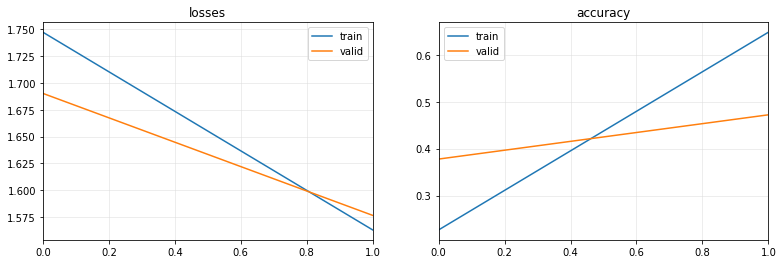

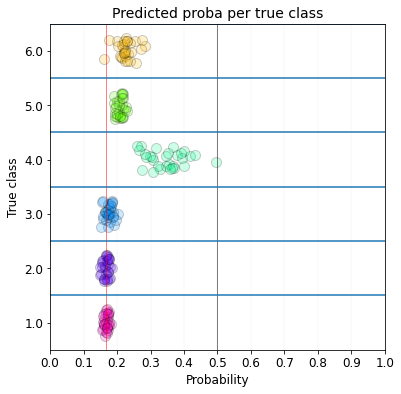

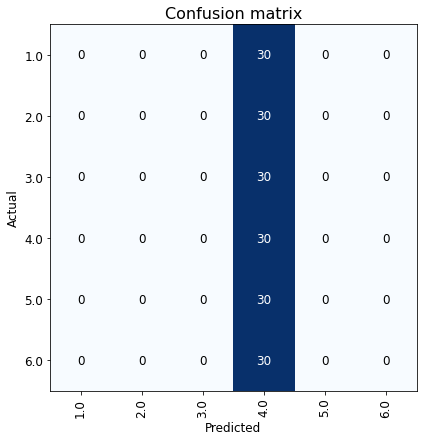

In [ ]:
from tsai.data.external import get_UCR_data
from tsai.data.preprocessing import TSRobustScale
from tsai.learner import ts_learner
from tsai.models.FCNPlus import FCNPlus
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, split_data=False)
tfms  = [None, [TSClassification()]]
batch_tfms = TSRobustScale()
dls = get_ts_dls(X, y, splits=splits, sel_vars=[0, 3, 5, 8, 10], sel_steps=slice(-30, None), tfms=tfms, batch_tfms=batch_tfms)
learn = ts_learner(dls, FCNPlus, metrics=accuracy, train_metrics=True)
learn.fit_one_cycle(2)
learn.plot_metrics()
learn.show_probas()
learn.plot_confusion_matrix()

Selected metric: accuracy
Computing feature importance...


  0 feature: BASELINE             accuracy: 0.166667


  1 feature: var_0                accuracy: 0.166667


  4 feature: var_3                accuracy: 0.166667


  6 feature: var_5                accuracy: 0.166667


  9 feature: var_8                accuracy: 0.166667


 11 feature: var_10               accuracy: 0.166667



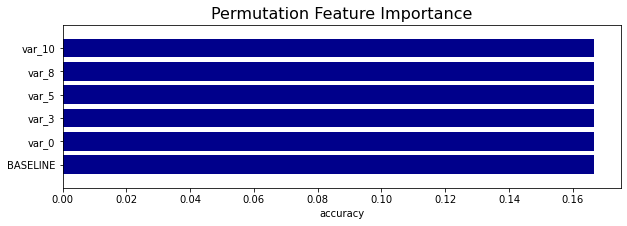

In [ ]:
learn.feature_importance();

Selected metric: accuracy
Computing feature importance...


  0 feature: BASELINE             accuracy: 0.166667


  1 feature: var_0                accuracy: 0.166667


  4 feature: var_3                accuracy: 0.166667


  6 feature: var_5                accuracy: 0.166667


  9 feature: var_8                accuracy: 0.166667


 11 feature: var_10               accuracy: 0.166667



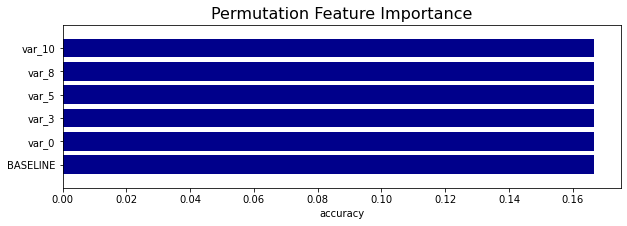

In [ ]:
learn.feature_importance(X=X[splits[1]], y=y[splits[1]]);

Selected metric: accuracy
Computing feature importance...


  0 feature: BASELINE             accuracy: 0.166667


  1 feature: var_0                accuracy: 0.166667


  4 feature: var_3                accuracy: 0.166667


  6 feature: var_5                accuracy: 0.166667


  9 feature: var_8                accuracy: 0.166667


 11 feature: var_10               accuracy: 0.166667



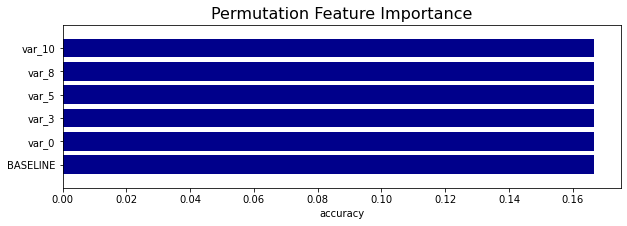

In [ ]:
learn.feature_importance(partial_n=.1);

Selected metric: accuracy
Computing feature importance...


  0 feature: BASELINE             accuracy: 0.200000


  1 feature: var_0                accuracy: 0.200000


  4 feature: var_3                accuracy: 0.200000


  6 feature: var_5                accuracy: 0.200000


  9 feature: var_8                accuracy: 0.200000


 11 feature: var_10               accuracy: 0.200000



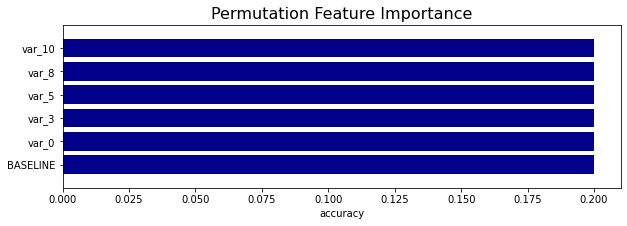

In [ ]:
learn.feature_importance(partial_n=10);

In [ ]:
#hide
from tsai.imports import create_scripts
from tsai.export import get_nb_name
nb_name = get_nb_name()
create_scripts(nb_name);

<IPython.core.display.Javascript object>

052b_analysis.ipynb saved at 2022-02-08 08:42:15.
Converted 052b_analysis.ipynb.


Correct conversion! 😃
Total time elapsed 0.111 s
Tuesday 08/02/22 08:42:19 CET
